In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline


from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

from datetime import datetime


end = datetime.now()
start = datetime(end.year - 10, end.month, end.day)

def fetch_stock_data(ticker, start, end):
    """
    Fetch historical stock data for the last 'period' days
    """
    data = yf.download(ticker, start=start, end=end)
    data.reset_index(inplace=True)
    return data

# Example usage
ticker = "AAPL"
stock_data = fetch_stock_data(ticker, start, end)
print(stock_data.tail())


C:\Users\Akshat\AppData\Local\Temp\ipykernel_39280\2945389679.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Price        Date       Close        High         Low        Open    Volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
2509   2025-08-27  230.490005  230.899994  228.259995  228.610001  31259500
2510   2025-08-28  232.559998  233.410004  229.339996  230.820007  38074700
2511   2025-08-29  232.139999  233.380005  231.369995  232.509995  39418400
2512   2025-09-02  229.720001  230.850006  226.970001  229.250000  43804400
2513   2025-09-03  235.960007  237.970001  234.369995  237.199997  32932612


In [5]:
stock_data

Price,Date,Close,High,Low,Open,Volume
Ticker,,AAPL,AAPL,AAPL,AAPL,AAPL
0,2015-09-03,24.802961,25.344549,24.728802,25.279378,212935600
1,2015-09-04,24.555765,24.820941,24.384975,24.488349,199985200
2,2015-09-08,25.238922,25.295103,24.791719,25.113076,219374400
3,2015-09-09,24.753521,25.623208,24.668124,25.564780,340043200
4,2015-09-10,25.297359,25.456914,24.697343,24.780490,251571200
...,...,...,...,...,...,...
2509,2025-08-27,230.490005,230.899994,228.259995,228.610001,31259500
2510,2025-08-28,232.559998,233.410004,229.339996,230.820007,38074700
2511,2025-08-29,232.139999,233.380005,231.369995,232.509995,39418400


In [ ]:
import os
import requests
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from dotenv import load_dotenv

# Load .env file
load_dotenv()

# Load API key from env
api_key = os.getenv("NEWSAPI_KEY")
if not api_key:
    raise ValueError("Please set NEWSAPI_KEY environment variable")

analyzer = SentimentIntensityAnalyzer()

def fetch_news(query, start_date, end_date):
    """Fetch articles from NewsAPI between given dates"""
    url = "https://newsapi.org/v2/everything"
    params = {
        "q": query,
        "from": start_date.strftime("%Y-%m-%d"),
        "to": end_date.strftime("%Y-%m-%d"),
        "language": "en",
        "sortBy": "relevancy",
        "pageSize": 100,
        "apiKey": api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return data.get("articles", [])

def compute_sentiment(articles):
    """Compute avg sentiment of article titles"""
    if not articles:
        return 0
    scores = [analyzer.polarity_scores(a["title"])["compound"] for a in articles if a.get("title")]
    return np.mean(scores) if scores else 0

def get_latest_sentiment(ticker):
    """Get sentiment for the last 30 days"""
    end_date = datetime.now()
    start_date = end_date - timedelta(days=30)

    articles = fetch_news(f"{ticker} stock", start_date, end_date)
    sentiment_score = compute_sentiment(articles)
    print(f"Latest sentiment ({start_date.date()} → {end_date.date()}): {sentiment_score}")
    return sentiment_score



In [41]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Use only price/volume columns for training (exclude sentiment)
features_for_training = stock_data[['Close', 'Volume']].values

# Scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features_for_training)

# Create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predict closing price
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(scaled_features, SEQ_LENGTH)

# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


c:\PROJECTS\STOCK\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 29s 227ms/step - loss: 0.0118 - val_loss: 0.0018
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 99ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 188ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 94ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0011 - val_loss: 0.0017
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - loss: 0.0011 - val_loss: 0.0041
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 190ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 13s 204ms/step - loss: 0.0010 - val_loss: 0.0012
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 9.9345e-04 - val_loss: 0.0017
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Latest sentiment (2025-08-05 → 2025-09-04): 0.09869


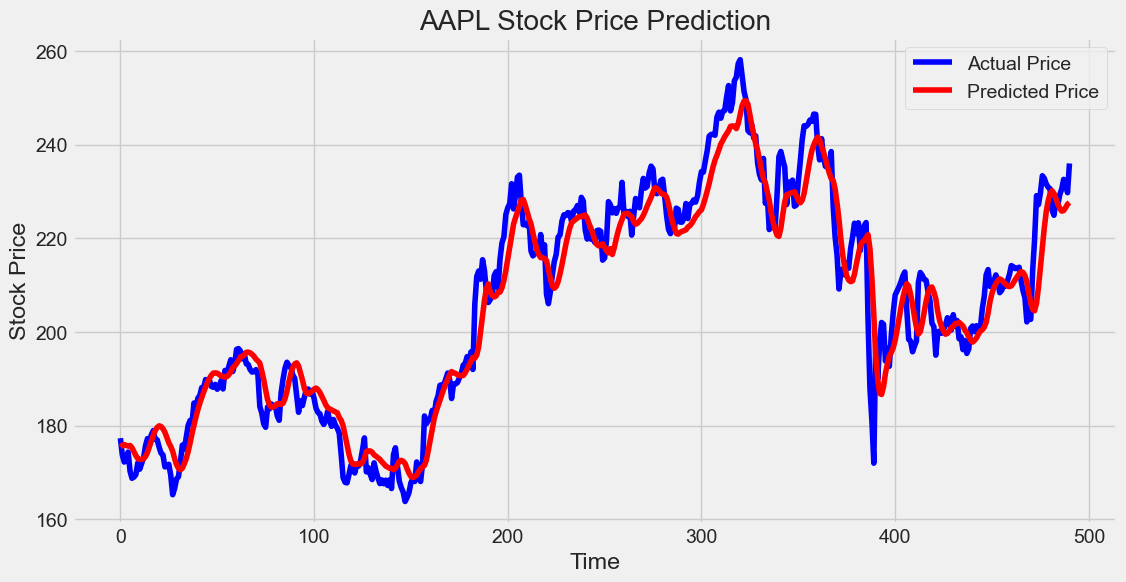

In [49]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
# Inverse scale to original values
latest_sentiment = get_latest_sentiment("AAPL")
alpha = 0.4
adjusted_price = y_pred * (1 + alpha * latest_sentiment)
y_test_scaled = scaler.inverse_transform(np.concatenate([y_test.reshape(-1,1), X_test[:, -1, 1:]], axis=1))[:,0]
y_pred_scaled = scaler.inverse_transform(np.concatenate([adjusted_price, X_test[:, -1, 1:]], axis=1))[:,0]

plt.figure(figsize=(12,6))
plt.plot(y_test_scaled, color='blue', label='Actual Price')
plt.plot(y_pred_scaled, color='red', label='Predicted Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [50]:
# save as app.py
import streamlit as st

st.title("Real-Time Stock Price Prediction")
ticker = st.text_input("Enter Stock Ticker", "AAPL")

if st.button("Predict"):
    stock_data = fetch_stock_data(ticker)
    
    features = stock_data[['Close','Volume']].values
    scaled_features = scaler.fit_transform(features)
    X, y = create_sequences(scaled_features)
    
    y_pred = model.predict(X[-SEQ_LENGTH:])
    latest_sentiment = get_latest_sentiment(ticker)
    alpha = 0.4
    adjusted_price = y_pred * (1 + alpha * latest_sentiment)
    y_pred_scaled = scaler.inverse_transform(np.concatenate([adjusted_price, X[:, -1, 1:]], axis=1))[:,0]
    st.write(f"Predicted next day closing price for {ticker}: {y_pred[-1][0]}")


2025-09-04 01:51:29.519 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 01:51:30.609 
  command:

    streamlit run c:\PROJECTS\STOCK\.venv\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-09-04 01:51:30.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 01:51:30.615 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 01:51:30.618 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 01:51:30.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 01:51:30.620 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-09-04 01:51:30.620 Thread 'MainThread': mis